# Demonstration and Validation

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Random Forest Example

Train the standard random forest example so we have something to score:

In [2]:
from tomo_challenge import load_data, load_redshift
from tomo_challenge.jax_metrics import ell_binning, compute_scores
from tomo_challenge.classifiers.random_forest import RandomForest

Found classifier Random
Found classifier RandomForest
Found classifier IBandOnly


Specify the challenge data to load:

In [3]:
bands='riz'
include_colors=True
include_errors=True

Load the training data:

In [4]:
training_file='/media/data2/tomo_challenge_data/ugrizy/training.hdf5'
train_data_arr = load_data(training_file, bands, 
                           errors=include_errors,
                           colors=include_colors, array=True)
training_z = load_redshift(training_file)
print(f'Loaded {len(train_data_arr)} training rows.')

/home/dkirkby/DESC/tomo/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


Loaded 8615613 training rows.


Load the validation data:

In [5]:
validation_file='/media/data2/tomo_challenge_data/ugrizy/validation.hdf5'
valid_data_arr = load_data(validation_file, bands, 
                           errors=include_errors,
                           colors=include_colors, array=True)
val_z = load_redshift(validation_file)
print(f'Loaded {len(valid_data_arr)} validation rows.')

Loaded 17228554 validation rows.


Initialize a random forest classifier with 4 bins:

In [6]:
nbins_rf = 4
classifier = RandomForest(bands, {'bins': nbins_rf})

Train on a fraction of the data:

In [7]:
ntrain_rf = 20000
classifier.train(train_data_arr[:ntrain_rf], training_z[:ntrain_rf])

Finding bins for training data
Fitting classifier


/opt/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test on a fraction of the validation data:

In [8]:
nvalid_rf = 50000
idx_rf = classifier.apply(valid_data_arr[:nvalid_rf])
z_rf = val_z[:nvalid_rf]

Plot true redshift distributions of the random forest bin assignments:

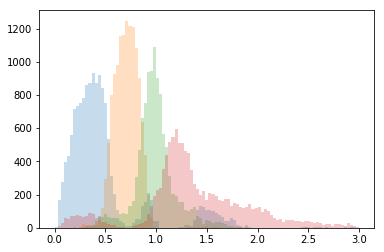

In [9]:
for bin in range(4):
    plt.hist(z_rf[idx_rf==bin], bins=np.linspace(0, 3, 100), alpha=0.25)

## Jax Cosmo Scores

Calculate scores using the jax_cosmo implementation provided with tomo_challenge. Note that they will vary slightly each time you retrain the random forest because it is random :-)

In [10]:
scores_rf = compute_scores(idx_rf, z_rf, metrics=['SNR_3x2', 'FOM_3x2', 'FOM_DETF_3x2'])
scores_rf

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


{'SNR_3x2': 1174.139892578125,
 'FOM_3x2': 2122.293701171875,
 'FOM_DETF_3x2': 46.321170806884766}

In [11]:
%timeit compute_scores(idx_rf, z_rf, metrics=['SNR_3x2', 'FOM_3x2', 'FOM_DETF_3x2'])

58.1 s ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Fast Reweighted Scores

Use reweighting to speed up the score calculation:

In [10]:
from zotbin.binned import *

Load the initialization data:

In [11]:
init_data = load_binned('binned_40.npz')

Calculate scores using the fast reweighting method:

In [12]:
scores = get_binned_scores(idx_rf, z_rf, *init_data)
scores

{'SNR_3x2': DeviceArray(1176.5612, dtype=float32),
 'FOM_3x2': DeviceArray(2050.5615, dtype=float32),
 'FOM_DETF_3x2': DeviceArray(43.05491, dtype=float32)}

In [13]:
%timeit get_binned_scores(idx_rf, z_rf, *init_data)

152 ms ± 914 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Plot the rows of the reweighting matrix, which is 4 x 40 in this case:

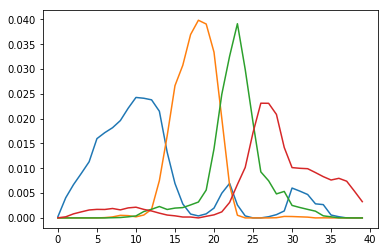

In [14]:
zedges = init_data[0]
weights = get_binned_weights(zedges, z_rf, idx_rf)
plt.plot(weights.T);